In [75]:
!pip install pyspark

In [131]:
from pyspark.sql.session import SparkSession
session=SparkSession.builder.appName("Weekly_Wagescsv").master("local[2]").getOrCreate()

In [77]:
wages_data=session.read.csv("Weekly_Wages.csv", header=True, inferSchema=True)

In [78]:
wages_data.show(2)

#View the selected columns of some rows
wages_data.select("Area Name", "Year", "Quarter").show(5)

+---------+--------------+----+-------+------------------+-----------+----------+--------------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+
|Area Type|     Area Name|Year|Quarter|         Ownership|NAICS Level|NAICS Code|       Industry Name|Establishments|Average Monthly Employment|1st Month Emp|2nd Month Emp|3rd Month Emp|Total Wages (All Workers)|Average Weekly Wages|
+---------+--------------+----+-------+------------------+-----------+----------+--------------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+
|   County|Alameda County|2016|1st Qtr|Federal Government|          2|      1023|Financial Activities|             1|                        10|           10|           10|           10|                 359690.0|              2767.0|
|   County|Alameda County|2016|1st Qtr|Federal Government|      

In [79]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# Defining functions
def new_column1_func(average_monthly_employment):
    if average_monthly_employment > 100:
        return 'Large Employment'
    else:
        return 'Small Employment'

def new_column2_func(average_weekly_wages):
    if average_weekly_wages > 2000:
        return 'High Weekly Wages'
    else:
        return 'Low Weekly Wages'

# Create user-defined functions
new_column1_udf = udf(new_column1_func, StringType())
new_column2_udf = udf(new_column2_func, StringType())

# Add new columns based on user-defined functions
wages_data = wages_data.withColumn('Employment_Size', new_column1_udf(wages_data['Average Monthly Employment']))
wages_data = wages_data.withColumn('Wages_Level', new_column2_udf(wages_data['Average Weekly Wages']))
# Display the results
wages_data.select("Average Monthly Employment", "Employment_Size").show(5)
wages_data.select("Average Weekly Wages", "Wages_Level").show(5)

+--------------------------+----------------+
|Average Monthly Employment| Employment_Size|
+--------------------------+----------------+
|                        10|Small Employment|
|                      5174|Large Employment|
|                        29|Small Employment|
|                        52|Small Employment|
|                        52|Small Employment|
+--------------------------+----------------+
only showing top 5 rows

+--------------------+-----------------+
|Average Weekly Wages|      Wages_Level|
+--------------------+-----------------+
|              2767.0|High Weekly Wages|
|              2023.0|High Weekly Wages|
|               560.0| Low Weekly Wages|
|              1107.0| Low Weekly Wages|
|              1107.0| Low Weekly Wages|
+--------------------+-----------------+
only showing top 5 rows



In [80]:
unique_values = wages_data.select('Industry Name').distinct()

# Show the unique values
unique_values.show()
unique_values.count()

+--------------------+
|       Industry Name|
+--------------------+
|Masonry Material ...|
|Building Material...|
| Janitorial Services|
|Food Services and...|
|  Poultry Hatcheries|
|Stone Mining and ...|
|Printing machiner...|
|Offices of Physic...|
|Offices of Physic...|
|Homes for the Eld...|
|All Other Animal ...|
|Fasteners, Button...|
|Research and Dvlp...|
|Other Converted P...|
|Material Handling...|
|Other Industrial ...|
|Funeral Homes and...|
|     Finfish Fishing|
|Soap and Other De...|
|Mineral Wool Manu...|
+--------------------+
only showing top 20 rows



1586

In [81]:
unique_values = wages_data.select('Ownership').distinct()

# Show the unique values
unique_values.show()
unique_values.count()

+------------------+
|         Ownership|
+------------------+
|Federal Government|
|  Total Government|
|  State Government|
|           Private|
|     Total Covered|
|Total U.I. Covered|
|  Local Government|
+------------------+



7

In [82]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def categorize_ownership(ownership):
    if ownership in ['Federal Government', 'State Government', 'Local Government']:
        return 'Government'
    elif ownership in ['Total Government', 'Total Covered', 'Total U.I. Covered']:
        return 'Total'
    else:
        return 'Private'

categorize_ownership_udf = udf(categorize_ownership, StringType())

wages_data = wages_data.withColumn('Ownership_Category', categorize_ownership_udf(wages_data['Ownership']))

wages_data.show()

+---------+--------------+----+-------+------------------+-----------+----------+--------------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+----------------+-----------------+------------------+
|Area Type|     Area Name|Year|Quarter|         Ownership|NAICS Level|NAICS Code|       Industry Name|Establishments|Average Monthly Employment|1st Month Emp|2nd Month Emp|3rd Month Emp|Total Wages (All Workers)|Average Weekly Wages| Employment_Size|      Wages_Level|Ownership_Category|
+---------+--------------+----+-------+------------------+-----------+----------+--------------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+----------------+-----------------+------------------+
|   County|Alameda County|2016|1st Qtr|Federal Government|          2|      1023|Financial Activities|             1|                   

In [83]:
from pyspark.sql.functions import avg

grouped_by_ownership_category = wages_data.groupBy('Ownership_Category').agg(avg('Average Monthly Employment').alias('Avg_Monthly_Employment'))
grouped_by_ownership_category.show()

+------------------+----------------------+
|Ownership_Category|Avg_Monthly_Employment|
+------------------+----------------------+
|             Total|     5478800.702380952|
|        Government|    23281.818662617756|
|           Private|    29224.690498696375|
+------------------+----------------------+



In [84]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

windowSpec = Window.partitionBy('Industry Name').orderBy(wages_data['Average Weekly Wages'].desc())

ranked_industries = wages_data.withColumn("Rank", rank().over(windowSpec))
ranked_industries.select("Industry Name", "Average Weekly Wages", "Rank").show()

+--------------------+--------------------+----+
|       Industry Name|Average Weekly Wages|Rank|
+--------------------+--------------------+----+
|AC, Refrigeration...|              2953.0|   1|
|AC, Refrigeration...|              2582.0|   2|
|AC, Refrigeration...|              2527.0|   3|
|AC, Refrigeration...|              2429.0|   4|
|AC, Refrigeration...|              2367.0|   5|
|AC, Refrigeration...|              2149.0|   6|
|AC, Refrigeration...|              2135.0|   7|
|AC, Refrigeration...|              1834.0|   8|
|AC, Refrigeration...|              1748.0|   9|
|AC, Refrigeration...|              1698.0|  10|
|AC, Refrigeration...|              1649.0|  11|
|AC, Refrigeration...|              1638.0|  12|
|AC, Refrigeration...|              1595.0|  13|
|AC, Refrigeration...|              1586.0|  14|
|AC, Refrigeration...|              1581.0|  15|
|AC, Refrigeration...|              1466.0|  16|
|AC, Refrigeration...|              1465.0|  17|
|AC, Refrigeration..

In [85]:
from pyspark.sql.functions import col, avg

avg_wages_by_industry = wages_data.groupBy('Industry Name').agg(avg('Average Weekly Wages').alias('Avg Weekly Wages'))

from pyspark.sql.window import Window
from pyspark.sql import functions as F

windowSpec = Window.orderBy(col('Avg Weekly Wages').desc())
ranked_industries = avg_wages_by_industry.withColumn('Rank', F.rank().over(windowSpec))

ranked_industries.show()


+--------------------+------------------+----+
|       Industry Name|  Avg Weekly Wages|Rank|
+--------------------+------------------+----+
|Sports Teams and ...| 4434.078048780488|   1|
|Investment Bankin...| 4402.047358834244|   2|
|All Other Informa...|      3993.6171875|   3|
|Electronic Comput...|3972.7445255474454|   4|
| Credit Card Issuing|3689.9411764705883|   5|
|Offices of Bank H...|3580.0689655172414|   6|
|Miscellaneous Int...|3518.3846153846152|   7|
|Security & Commod...|  3378.71452991453|   8|
|Open-End Investme...|3337.6393442622953|   9|
|Securities Brokerage| 3183.328025477707|  10|
|Motion Picture an...|3147.4903846153848|  11|
|Semiconductor and...|3088.1058020477817|  12|
|Computers and Per...|3025.7341269841268|  13|
|Semiconductor Mac...| 2928.507042253521|  14|
|Crude Petroleum E...| 2894.705882352941|  15|
|Research and Deve...| 2881.153153153153|  16|
|Portfolio Management| 2870.237359550562|  17|
|Transportation Eq...|2847.1521739130435|  18|
|Securities a

In [86]:
#Installing the necessary libraries
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes

In [87]:
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

In [88]:
from graphframes import *
from pyspark import *
from pyspark.sql import *
spark = SparkSession.builder.appName('myfunction').getOrCreate()

In [89]:
print("Number of observations:",wages_data.count())
print("Information of columns:\n",wages_data.columns)
print("Description of columns:\n",wages_data.describe().show())
print("First few records:\n", wages_data.show())

Number of observations: 1009955
Information of columns:
 ['Area Type', 'Area Name', 'Year', 'Quarter', 'Ownership', 'NAICS Level', 'NAICS Code', 'Industry Name', 'Establishments', 'Average Monthly Employment', '1st Month Emp', '2nd Month Emp', '3rd Month Emp', 'Total Wages (All Workers)', 'Average Weekly Wages', 'Employment_Size', 'Wages_Level', 'Ownership_Category']
+-------+--------------------+--------------+-----------------+-------+------------------+-----------------+------------------+--------------------+-----------------+--------------------------+------------------+------------------+------------------+-------------------------+--------------------+----------------+-----------------+------------------+
|summary|           Area Type|     Area Name|             Year|Quarter|         Ownership|      NAICS Level|        NAICS Code|       Industry Name|   Establishments|Average Monthly Employment|     1st Month Emp|     2nd Month Emp|     3rd Month Emp|Total Wages (All Workers)|Av

In [90]:
from pyspark.sql.functions import col, sum as spark_sum
missing_value_counts = wages_data.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in wages_data.columns])
missing_value_counts.show()

+---------+---------+----+-------+---------+-----------+----------+-------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+---------------+-----------+------------------+
|Area Type|Area Name|Year|Quarter|Ownership|NAICS Level|NAICS Code|Industry Name|Establishments|Average Monthly Employment|1st Month Emp|2nd Month Emp|3rd Month Emp|Total Wages (All Workers)|Average Weekly Wages|Employment_Size|Wages_Level|Ownership_Category|
+---------+---------+----+-------+---------+-----------+----------+-------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+---------------+-----------+------------------+
|        0|        0|   0|      0|        0|          0|         0|            0|             0|                         0|            0|            0|            0|                        0|                   0|        

In [91]:
quarterly_avg_wages = wages_data.groupBy('Quarter').agg(avg('Average Weekly Wages'))
quarterly_avg_wages.show()

+-------+-------------------------+
|Quarter|avg(Average Weekly Wages)|
+-------+-------------------------+
| Annual|       1101.9537434101817|
|3rd Qtr|       1069.7481810316008|
|1st Qtr|       1082.5780526114984|
|2nd Qtr|       1045.7130372274166|
|4th Qtr|       1165.5008044301658|
+-------+-------------------------+



The analysis indicates that there are indeed particular quarters or times of the year when wages tend to be higher or lower. Specifically, the 4th quarter stands out as having the highest average weekly wages, with an average of   1165.50. Conversely, the 2nd quarter has the lowest average weekly wages, with an average of $1045.71. This suggests a seasonal pattern where wages peak towards the end of the year and dip in the middle of the year. Further exploration into the factors driving these seasonal variations could provide valuable insights for understanding wage dynamics and informing workforce management strategies.

In [92]:
avg_wages_by_ownership = wages_data.groupBy('Ownership').agg(avg('Total Wages (All Workers)').alias('Avg_Total_Wages')).orderBy('Avg_Total_Wages', ascending=False)
avg_wages_by_ownership.show()

+------------------+--------------------+
|         Ownership|     Avg_Total_Wages|
+------------------+--------------------+
|Total U.I. Covered|  3.1796951938478E12|
|  Total Government| 2.78459437065225E11|
|     Total Covered|6.969340021270334E10|
|  Local Government|  9.98528808236783E8|
|  State Government| 7.296048602678796E8|
|           Private| 6.811320314734694E8|
|Federal Government| 1.933855053316736E8|
+------------------+--------------------+



The analysis reveals notable differences in wages between different types of ownership. Here's a breakdown of the average total wages across various ownership categories:

Total U.I. Covered:   3.18 trillion

Total Government:   278.46 billion

Total Covered:   69.69 billion

Local Government:   998.53 million

State Government:   729.60 million

Private:   681.13 million

Federal Government:   193.39 million

These figures indicate significant variations in average total wages across different ownership categories. Particularly, the private sector appears to have the highest average total wages, followed by various levels of government (local, state, and federal). Understanding these wage disparities can provide insights into the economic landscape, labor market dynamics, and the distribution of resources across different sectors of the economy. Further analysis may be necessary to explore the factors contributing to these differences and their implications for various stakeholders.

In [93]:
ownership_analysis = wages_data.groupBy('Ownership') \
    .agg(avg('Total Wages (All Workers)').alias('Avg_Total_Wages'),
         avg('Average Monthly Employment').alias('Avg_Monthly_Employment'),
         avg('Establishments').alias('Avg_Establishments')) \
    .orderBy('Avg_Total_Wages', ascending=False)
ownership_analysis.show()

+------------------+--------------------+----------------------+------------------+
|         Ownership|     Avg_Total_Wages|Avg_Monthly_Employment|Avg_Establishments|
+------------------+--------------------+----------------------+------------------+
|Total U.I. Covered|  3.1796951938478E12|         1.421851135E8|         9898939.2|
|  Total Government| 2.78459437065225E11|        1.2004739675E7|        167752.825|
|     Total Covered|6.969340021270334E10|    2982830.8566666665|216263.14916666667|
|  Local Government|  9.98528808236783E8|     46922.46358171636| 553.2407220290798|
|  State Government| 7.296048602678796E8|     29160.57466417276|502.87757184152355|
|           Private| 6.811320314734694E8|    29224.690498696375| 2387.583379032336|
|Federal Government| 1.933855053316736E8|     5901.843976233901|119.01531816808584|
+------------------+--------------------+----------------------+------------------+



Based on the provided results, there are noticeable differences in wage levels and employment stability based on ownership structure:

**Wage Levels:**

Total U.I. Covered has the highest average total wages, followed by Total Government and Total Covered.
Private ownership also shows relatively high average total wages compared to Federal Government, State Government, and Local Government.

**Employment Stability:**

Total U.I. Covered has the highest average monthly employment, indicating potentially more stable employment within this ownership category.
Private ownership also shows a relatively high average monthly employment level compared to Federal Government, State Government, and Local Government.
Overall, ownership structure appears to influence both wage levels and employment stability, with certain categories such as Total U.I. Covered showing higher values in both metrics compared to others. Further analysis may be required to understand the underlying factors contributing to these differences.

In [94]:
avg_wages_by_area = wages_data.withColumn("Total Wages (All Workers)", col("Total Wages (All Workers)").cast("int")) \
    .groupBy('Area Name') \
    .agg(avg('Total Wages (All Workers)').alias('Avg_Total_Wages')) \
    .orderBy('Avg_Total_Wages', ascending=False)
avg_wages_by_area.show()


+--------------------+--------------------+
|           Area Name|     Avg_Total_Wages|
+--------------------+--------------------+
|       United States| 8.217235896315587E8|
|          California| 3.908397139742851E8|
|  Los Angeles County|2.0281936319469732E8|
|  Santa Clara County|1.2868122679611683E8|
|       Orange County|1.1358862038236283E8|
|San Francisco County|1.1301399257965653E8|
|    San Diego County|1.0500663556222329E8|
|      Alameda County| 8.467441198300202E7|
|    San Mateo County|  7.80729353725048E7|
|   Sacramento County| 6.769789534985678E7|
| Contra Costa County| 5.078930814271511E7|
|San Bernardino Co...| 5.076921159470752E7|
|    Riverside County|5.0388638517435685E7|
|       Fresno County|3.7293356032769725E7|
|      Ventura County| 3.719833190700353E7|
|         Kern County| 3.613596541374294E7|
|  San Joaquin County|2.9293886737683207E7|
|       Placer County|2.7198878472865757E7|
|     Monterey County|2.6696952242359083E7|
|       Sonoma County|      2.66

There are significant variations in wages between different regions or areas:

**Highest Average Wages:**

The United States has the highest average total wages, followed by California. Los Angeles County, Santa Clara County, and Orange County also have relatively high average total wages.

**Variations Across Counties:**

There are noticeable variations in average wages across different counties within California. For example, San Francisco County, San Diego County, and Alameda County have relatively high average total wages, while other counties like Fresno County and Kern County have lower average total wages.

**Regional Disparities:**

There are disparities in wages between regions, with some areas experiencing higher average wages compared to others. This indicates that wage levels may vary significantly depending on the geographical location or area. Overall, the analysis highlights significant variations in wages between different regions or areas, suggesting the presence of regional economic disparities. Further investigation may be required to understand the underlying factors contributing to these variations.

In [95]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# Defining functions
def new_column1_func(average_monthly_employment):
    if average_monthly_employment > 100:
        return 'Large Employment'
    else:
        return 'Small Employment'

# Create user-defined functions
new_column1_udf = udf(new_column1_func, StringType())


# Add new columns based on user-defined functions
wages_data = wages_data.withColumn('Employment_Size', new_column1_udf(wages_data['Average Monthly Employment']))

# Display the results
wages_data.select("Average Monthly Employment", "Employment_Size").show(5)


+--------------------------+----------------+
|Average Monthly Employment| Employment_Size|
+--------------------------+----------------+
|                        10|Small Employment|
|                      5174|Large Employment|
|                        29|Small Employment|
|                        52|Small Employment|
|                        52|Small Employment|
+--------------------------+----------------+
only showing top 5 rows



In [96]:
def calculate_increase(first_month_emp, third_month_emp):
    return third_month_emp - first_month_emp
increase_udf = udf(calculate_increase, IntegerType())
wages_data1 = wages_data.withColumn('Increase_in_Employment', increase_udf(col('1st Month Emp'), col('3rd Month Emp')))
wages_data1.select('1st Month Emp', '3rd Month Emp', 'Increase_in_Employment').show(20)

+-------------+-------------+----------------------+
|1st Month Emp|3rd Month Emp|Increase_in_Employment|
+-------------+-------------+----------------------+
|           10|           10|                     0|
|         5193|         5188|                    -5|
|           31|           29|                    -2|
|           61|           31|                   -30|
|           61|           31|                   -30|
|          127|           95|                   -32|
|         1804|         1762|                   -42|
|         2383|         2351|                   -32|
|         2991|         3050|                    59|
|         2628|         2722|                    94|
|          511|          566|                    55|
|          511|          566|                    55|
|        28601|        29230|                   629|
|         1105|         1228|                   123|
|            9|           10|                     1|
|            9|           10|                 

In [97]:
from pyspark.sql.functions import col,avg
avg_wages_by_area = wages_data.withColumn("Average Weekly Wages", col("Average Weekly Wages").cast("int")).groupBy('Area Name')\
    .agg(avg('Average Weekly Wages').alias('Avg_Weekly_Wages'))\
    .orderBy('Avg_Weekly_Wages', ascending=False)
avg_wages_by_area.show()

+--------------------+------------------+
|           Area Name|  Avg_Weekly_Wages|
+--------------------+------------------+
|San Francisco County|1740.8844191752016|
|    San Mateo County|1588.3412260920404|
|  Santa Clara County|1577.8184806180536|
|      Alameda County|1376.0031371042608|
| Contra Costa County|1333.8884792244914|
|          California|1315.8080240506781|
|        Marin County|1307.5298961096375|
|  Los Angeles County|1296.4409154174368|
|       Orange County| 1254.555935050392|
|    San Diego County|1176.7267984546404|
|       United States|1142.7879796997588|
|   Sacramento County|1123.1061971634178|
|         Napa County|1114.0804670242978|
|      Ventura County|  1110.51505145139|
|       Sonoma County|1092.0657872340425|
|Santa Barbara County|1069.3831379068954|
|       Placer County|1049.1591029302867|
|         Yolo County| 1044.895502917954|
|     Monterey County|1026.7200122868992|
|   Santa Cruz County|1020.7950658654958|
+--------------------+------------

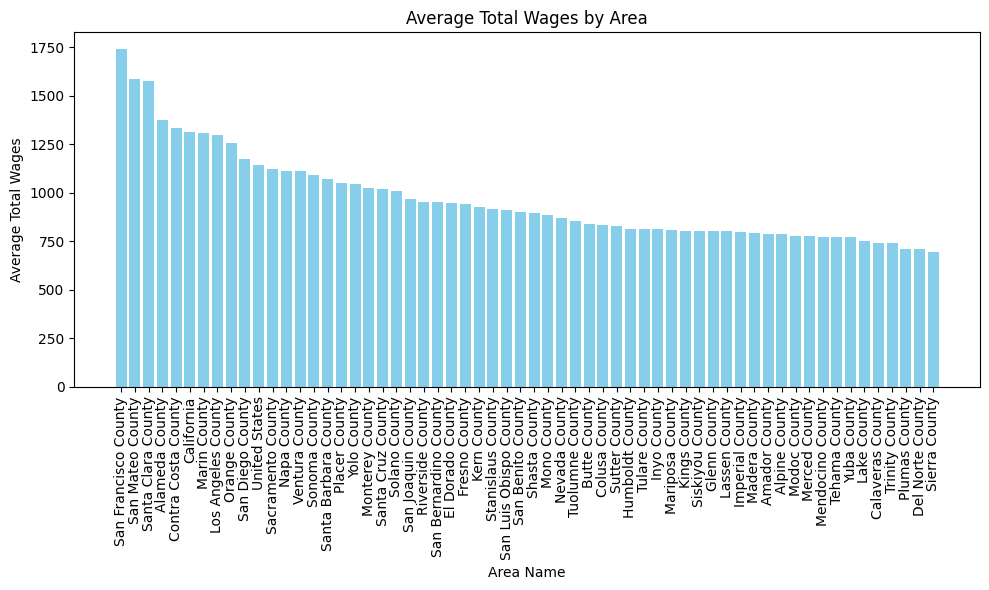

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

avg_wages_by_area_pd = avg_wages_by_area.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(avg_wages_by_area_pd['Area Name'], avg_wages_by_area_pd['Avg_Weekly_Wages'], color='skyblue')
plt.xlabel('Area Name')
plt.ylabel('Average Total Wages')
plt.title('Average Total Wages by Area')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [99]:
wages_data = wages_data.withColumn("Average Weekly Wages", col("Average Weekly Wages").cast("int"))
avg_wages_by_industry = wages_data.groupBy('Industry Name') \
                                   .agg(avg('Average Weekly Wages').alias('Avg_Weekly_Wages')) \
                                   .orderBy('Avg_Weekly_Wages', ascending=False)

avg_wages_by_industry.show(5)

+--------------------+------------------+
|       Industry Name|  Avg_Weekly_Wages|
+--------------------+------------------+
|Sports Teams and ...| 4434.078048780488|
|Investment Bankin...| 4402.047358834244|
|All Other Informa...|      3993.6171875|
|Electronic Comput...|3972.7445255474454|
| Credit Card Issuing|3689.9411764705883|
+--------------------+------------------+
only showing top 5 rows



In [100]:
# Calculate the count for each category
category_counts = wages_data.groupBy("Industry Name").count()

# Calculate the total count of the dataset
total_count = wages_data.count()

# Calculate the desired sample size per category (1% of total)
sample_size = int(0.000001 * total_count)

# Define a fraction for each category to maintain the proportional representation
fractions = {row["Industry Name"]: min(1.0, sample_size / row["count"]) for row in category_counts.collect()}

# Use stratified sampling to create the subset
subset = wages_data.sampleBy("Industry Name", fractions, seed=1000)

# Show the resulting subset
subset.count()


1534

In [101]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

#String indexing for categorical columns
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["Area Type","Area Name","Year","Quarter", "Industry Name", "NAICS Level","NAICS Code","Ownership", "Employment_Size"],
                      outputCols=["newArea Type","newArea Name","newYear","newQuarter", "newIndustry Name", "newNAICS Level", "newNAICS Code", "newOwnership", "newEmployment_Size"])
#One hot encoding
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["newArea Type","newArea Name","newYear","newQuarter", "newIndustry Name","newNAICS Level", "newNAICS Code", "newOwnership","newEmployment_Size"],
                         outputCols=["newArea Type2","newArea Name2","newYear2","newQuarter2", "newIndustry Name2", "newNAICS Level2", "newNAICS Code2", "newOwnership2","newEmployment_Size2"])
#Vector Assembler
from pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["newArea Type2","newArea Name2","newYear2","newQuarter2", "newIndustry Name2", "newNAICS Level2", "newNAICS Code2", "newOwnership2","newEmployment_Size2",
                                   "Total Wages (All Workers)","Average Monthly Employment","Establishments"],outputCol="all_features")

#Splitting the dataset
training, test=wages_data.randomSplit([0.8,0.2], seed=123)

#Creating an Object of  Linear Regression
from pyspark.ml.regression import LinearRegression
lr=LinearRegression(featuresCol="all_features", labelCol="Average Weekly Wages")


In [102]:
#Creating the pipeline
from pyspark.ml import Pipeline
lrpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,lr])

#Training the Model
lrmodel=lrpipeline.fit(training)

#Predicting the model
lrresults=lrmodel.transform(test)
lrresults.show(5)

+--------------------+----------+----+-------+------------------+-----------+----------+--------------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+----------------+-----------------+------------------+------------+------------+-------+----------+----------------+--------------+-------------+------------+------------------+-------------+--------------+---------+-------------+------------------+---------------+------------------+-------------+-------------------+--------------------+------------------+
|           Area Type| Area Name|Year|Quarter|         Ownership|NAICS Level|NAICS Code|       Industry Name|Establishments|Average Monthly Employment|1st Month Emp|2nd Month Emp|3rd Month Emp|Total Wages (All Workers)|Average Weekly Wages| Employment_Size|      Wages_Level|Ownership_Category|newArea Type|newArea Name|newYear|newQuarter|newIndustry Name|newNAICS Level|newNAICS Code|newOwnership|new

In [103]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='Average Weekly Wages', predictionCol='prediction', metricName='r2')

# Evaluate the performance using the chosen metric
r2 = evaluator.evaluate(lrresults)
print(f"R-squared: {r2}")

evaluator = RegressionEvaluator(labelCol='Average Weekly Wages', predictionCol='prediction', metricName='rmse')

# Evaluate the performance using the chosen metric
rmse = evaluator.evaluate(lrresults)
print(f"rmse: {rmse}")

R-squared: 0.5312309442025673
rmse: 502.16601954940745


In [104]:
lrresults.select('prediction', 'Average Weekly Wages').show(5)

# Calculate the average change in wages
avg_change = (
    lrresults
    .groupBy()
    .agg({'prediction': 'avg', 'Average Weekly Wages': 'avg'})
    .withColumn('AverageChange', col('avg(prediction)') - col('avg(Average Weekly Wages)'))
    .select('AverageChange')
    .collect()[0]['AverageChange']
)

print(f"The average change in wages for the next year is: {avg_change}")


+------------------+--------------------+
|        prediction|Average Weekly Wages|
+------------------+--------------------+
|1471.6441061909354|                1494|
|1828.7589655465067|                2696|
|1104.5485300754442|                   0|
|1509.2903708138638|                2576|
|1813.0418717842242|                1629|
+------------------+--------------------+
only showing top 5 rows

The average change in wages for the next year is: -1.1932543604161765


In [105]:
from pyspark.ml.regression import DecisionTreeRegressor
# tree=DecisionTreeRegressor(featuresCol="all_features", labelCol="Average Weekly Wages")
# stages = indexers + encoders + [vec_obj, tree]
# treepipeline=Pipeline(stages=stages)
# treemodel=treepipeline.fit(training)
# treeresults=treemodel.transform(test)
# treeresults.show(5)

# Creating an object of Decision Tree Regression
dt = DecisionTreeRegressor(featuresCol="all_features", labelCol="Average Weekly Wages")

# Creating the pipeline
dtpipeline = Pipeline(stages=[str_obj, onehot_obj, vec_obj, dt])

# Training the model
dtmodel = dtpipeline.fit(training)

# Predicting with the model
dtresults = dtmodel.transform(test)
dtresults.show(5)

+--------------------+----------+----+-------+------------------+-----------+----------+--------------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+----------------+-----------------+------------------+------------+------------+-------+----------+----------------+--------------+-------------+------------+------------------+-------------+--------------+---------+-------------+------------------+---------------+------------------+-------------+-------------------+--------------------+------------------+
|           Area Type| Area Name|Year|Quarter|         Ownership|NAICS Level|NAICS Code|       Industry Name|Establishments|Average Monthly Employment|1st Month Emp|2nd Month Emp|3rd Month Emp|Total Wages (All Workers)|Average Weekly Wages| Employment_Size|      Wages_Level|Ownership_Category|newArea Type|newArea Name|newYear|newQuarter|newIndustry Name|newNAICS Level|newNAICS Code|newOwnership|new

In [106]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='Average Weekly Wages', predictionCol='prediction', metricName='r2')

# Evaluate the performance using the chosen metric
r2 = evaluator.evaluate(dtresults)
print(f"R-squared: {r2}")

R-squared: 0.20198522511352224


In [107]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
treeeval=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="Average Weekly Wages")
treeeval.evaluate(dtresults)

0.9805926020350433

In [108]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator1=RegressionEvaluator(predictionCol="prediction", labelCol="Average Weekly Wages", metricName="rmse")
print("RMSE:",evaluator1.evaluate(dtresults))
evaluator2=RegressionEvaluator(predictionCol="prediction", labelCol="Average Weekly Wages", metricName="mse")
print("MSE:",evaluator2.evaluate(dtresults))
evaluator3=RegressionEvaluator(predictionCol="prediction", labelCol="Average Weekly Wages", metricName="mae")
print("MAE:",evaluator3.evaluate(dtresults))
evaluator4=RegressionEvaluator(predictionCol="prediction", labelCol="Average Weekly Wages", metricName="r2")
print("R- Squared:",evaluator4.evaluate(dtresults))

RMSE: 655.1991419414471
MSE: 429285.9156008085
MAE: 417.776595229665
R- Squared: 0.20198522511352224


In [109]:
def calculate_increase(first_month_emp, third_month_emp):
    return third_month_emp - first_month_emp
increase_udf = udf(calculate_increase, IntegerType())
wages_data = wages_data.withColumn('Increase_in_Employment', increase_udf(col('1st Month Emp'), col('3rd Month Emp')))
wages_data.select('1st Month Emp', '3rd Month Emp', 'Increase_in_Employment').show(20)

+-------------+-------------+----------------------+
|1st Month Emp|3rd Month Emp|Increase_in_Employment|
+-------------+-------------+----------------------+
|           10|           10|                     0|
|         5193|         5188|                    -5|
|           31|           29|                    -2|
|           61|           31|                   -30|
|           61|           31|                   -30|
|          127|           95|                   -32|
|         1804|         1762|                   -42|
|         2383|         2351|                   -32|
|         2991|         3050|                    59|
|         2628|         2722|                    94|
|          511|          566|                    55|
|          511|          566|                    55|
|        28601|        29230|                   629|
|         1105|         1228|                   123|
|            9|           10|                     1|
|            9|           10|                 

In [110]:
wages_data.show(2)

+---------+--------------+----+-------+------------------+-----------+----------+--------------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+----------------+-----------------+------------------+----------------------+
|Area Type|     Area Name|Year|Quarter|         Ownership|NAICS Level|NAICS Code|       Industry Name|Establishments|Average Monthly Employment|1st Month Emp|2nd Month Emp|3rd Month Emp|Total Wages (All Workers)|Average Weekly Wages| Employment_Size|      Wages_Level|Ownership_Category|Increase_in_Employment|
+---------+--------------+----+-------+------------------+-----------+----------+--------------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+----------------+-----------------+------------------+----------------------+
|   County|Alameda County|2016|1st Qtr|Federal Government|         

In [111]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

#String indexing for categorical columns
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["Area Type","Area Name","Year","Quarter", "Industry Name", "NAICS Level","NAICS Code","Ownership", "Employment_Size"],
                      outputCols=["newArea Type","newArea Name","newYear","newQuarter", "newIndustry Name", "newNAICS Level", "newNAICS Code", "newOwnership", "newEmployment_Size"])
#One hot encoding
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["newArea Type","newArea Name","newYear","newQuarter", "newIndustry Name","newNAICS Level", "newNAICS Code", "newOwnership","newEmployment_Size"],
                         outputCols=["newArea Type2","newArea Name2","newYear2","newQuarter2", "newIndustry Name2", "newNAICS Level2", "newNAICS Code2", "newOwnership2","newEmployment_Size2"])
#Vector Assembler
from pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["newArea Type2","newArea Name2","newYear2","newQuarter2", "newIndustry Name2", "newNAICS Level2", "newNAICS Code2", "newOwnership2","newEmployment_Size2",
                                   "Total Wages (All Workers)","Average Monthly Employment","Establishments","Increase_in_Employment"],outputCol="all_features")

#Splitting the dataset
training, test=wages_data.randomSplit([0.8,0.2], seed=123)

from pyspark.ml.regression import RandomForestRegressor
# Random Forest Classifier
rf = RandomForestRegressor(featuresCol='all_features', labelCol="Average Weekly Wages")


In [112]:
#Creating the pipeline
from pyspark.ml import Pipeline
rfpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,rf])

In [113]:
#Training the Model
rfmodel=rfpipeline.fit(training)

#Predicting the model
rfresults=rfmodel.transform(test)
rfresults.show(5)

+--------------------+----------+----+-------+------------------+-----------+----------+--------------------+--------------+--------------------------+-------------+-------------+-------------+-------------------------+--------------------+----------------+-----------------+------------------+----------------------+------------+------------+-------+----------+----------------+--------------+-------------+------------+------------------+-------------+--------------+---------+-------------+------------------+---------------+------------------+-------------+-------------------+--------------------+------------------+
|           Area Type| Area Name|Year|Quarter|         Ownership|NAICS Level|NAICS Code|       Industry Name|Establishments|Average Monthly Employment|1st Month Emp|2nd Month Emp|3rd Month Emp|Total Wages (All Workers)|Average Weekly Wages| Employment_Size|      Wages_Level|Ownership_Category|Increase_in_Employment|newArea Type|newArea Name|newYear|newQuarter|newIndustry Name

In [114]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator1=RegressionEvaluator(predictionCol="prediction", labelCol="Average Weekly Wages", metricName="rmse")
print("RMSE:",evaluator1.evaluate(rfresults))
evaluator2=RegressionEvaluator(predictionCol="prediction", labelCol="Average Weekly Wages", metricName="mse")
print("MSE:",evaluator2.evaluate(rfresults))
evaluator3=RegressionEvaluator(predictionCol="prediction", labelCol="Average Weekly Wages", metricName="mae")
print("MAE:",evaluator3.evaluate(rfresults))
evaluator4=RegressionEvaluator(predictionCol="prediction", labelCol="Average Weekly Wages", metricName="r2")
print("R- Squared:",evaluator4.evaluate(rfresults))

RMSE: 641.892902637405
MSE: 412026.4984562731
MAE: 408.9188153117857
R- Squared: 0.23406936621093455


In [115]:
data=session.read.csv("Weekly_Wages.csv", header=True, inferSchema=True)
data.count()

1009955

In [116]:
data.printSchema()

root
 |-- Area Type: string (nullable = true)
 |-- Area Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Ownership: string (nullable = true)
 |-- NAICS Level: integer (nullable = true)
 |-- NAICS Code: string (nullable = true)
 |-- Industry Name: string (nullable = true)
 |-- Establishments: integer (nullable = true)
 |-- Average Monthly Employment: integer (nullable = true)
 |-- 1st Month Emp: integer (nullable = true)
 |-- 2nd Month Emp: integer (nullable = true)
 |-- 3rd Month Emp: integer (nullable = true)
 |-- Total Wages (All Workers): double (nullable = true)
 |-- Average Weekly Wages: double (nullable = true)



In [117]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans

# Create a VectorAssembler
assembler = VectorAssembler(inputCols=['Average Weekly Wages'],
                            outputCol='features')

# Create a KMeans model
kmeans = KMeans(featuresCol='features', predictionCol='cluster', k=3)  # You can adjust 'k' based on your needs

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, kmeans])

# Fit the pipeline to the data
model = pipeline.fit(data)

# Make predictions
clustered_df = model.transform(data)

# You can further analyze the clusters, for example, by calculating the mean values for each cluster
cluster_summary = clustered_df.groupBy('cluster').agg({'Total Wages (All Workers)': 'mean',
                                                       'Average Weekly Wages': 'mean'})

cluster_summary.show()


+-------+------------------------------+-------------------------+
|cluster|avg(Total Wages (All Workers))|avg(Average Weekly Wages)|
+-------+------------------------------+-------------------------+
|      1|           9.616626739084991E8|       1744.9003052064631|
|      2|           1.709175751803287E9|        4771.330241051863|
|      0|           7.391907230236971E8|        769.5629224049654|
+-------+------------------------------+-------------------------+



In [118]:
from pyspark.sql.functions import when

# Assuming 'clustered_df' is your DataFrame with cluster assignments
clustered_df = clustered_df.withColumn(
    'cluster_name',
    when(clustered_df['cluster'] == 0, 'Low Wage Industries')
    .when(clustered_df['cluster'] == 1, 'Medium Wage Industries')
    .when(clustered_df['cluster'] == 2, 'High Wage Industries')
    .otherwise('Unknown Cluster')
)

# Show the resulting DataFrame with cluster names
clustered_df.select('Industry Name', 'Average Weekly Wages', 'cluster', 'cluster_name').show(7)

+--------------------+--------------------+-------+--------------------+
|       Industry Name|Average Weekly Wages|cluster|        cluster_name|
+--------------------+--------------------+-------+--------------------+
|Financial Activities|              2767.0|      1|Medium Wage Indus...|
|Public Administra...|              2023.0|      1|Medium Wage Indus...|
|Vegetable and Mel...|               560.0|      0| Low Wage Industries|
|Greenhouse and Nu...|              1107.0|      0| Low Wage Industries|
|Nursery and Flori...|              1107.0|      0| Low Wage Industries|
|Support Activitie...|               639.0|      0| Low Wage Industries|
|New Single-Family...|              1330.0|      1|Medium Wage Indus...|
+--------------------+--------------------+-------+--------------------+
only showing top 7 rows



In [119]:
# You can further analyze the clusters, for example, by calculating the mean values for each cluster
cluster_summary = clustered_df.groupBy('cluster').agg({'Average Weekly Wages': 'max'})

cluster_summary.show()

+-------+-------------------------+
|cluster|max(Average Weekly Wages)|
+-------+-------------------------+
|      1|                   3274.0|
|      2|                  29502.0|
|      0|                   1260.0|
+-------+-------------------------+



# **Graph**

In [120]:
#Installing the necessary libraries
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes

In [136]:
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1 pyspark-shell"

In [137]:
from graphframes import *
from graphframes import GraphFrame
from pyspark import *
from pyspark.sql import *

In [138]:
vertices = spark.read.option('header', 'true').csv('nodes.csv')
edges = spark.read.option('header', 'true').csv('edges.csv')

In [139]:
vertices.show(5)
edges.show(5)

+---+--------------------+
| id|                Name|
+---+--------------------+
|  1|Apparel accessori...|
|  2|    Used Car Dealers|
|  3|Residential Elect...|
|  4|       Wheat Farming|
|  5|Printed Circuit A...|
+---+--------------------+
only showing top 5 rows

+---+---+--------+
|src|dst|relation|
+---+---+--------+
|  1| 50|Owned By|
|  2| 50|Owned By|
|  3| 50|Owned By|
|  4| 50|Owned By|
|  5| 50|Owned By|
+---+---+--------+
only showing top 5 rows



In [140]:
mygraph = GraphFrame(vertices, edges)

Py4JJavaError: An error occurred while calling o3334.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:594)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:527)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# the function will plot the source and destination nodes and connect them by meand of undirected line
def plot_undirected_graph(edge_list):
    plt.figure(figsize=(9,9))
    gplot=nx.Graph()
    for row in edge_list.select("src", "dst").take(500):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot,with_labels=True, node_size=200)
plot_undirected_graph(mygraph.edges)

In [ ]:
result4=mygraph.filterEdges("relation='Owned By'");
result4.vertices.show()
result4.edges.show()

In [ ]:
from pyspark.sql.functions import desc
sorted_vertices = x.vertices.orderBy(desc("pagerank"))
sorted_vertices.show()

In [ ]:
mygraph.triangleCount().show()